# <오늘 할 것: >

# 1. 도형 분류 예제
- 1-1. 도형 준비
- 1-2. 모델 구축하기
- 1-3. 모델 학습/평가하기

# 2. 성능 개선하기
- 2-1. 모델 뜯어보기
- 2-2. 중간 결과 출력해보기
    - 2-2-1. Flatten Layer 출력값 확인하기
    - 2-2-2. Output Layer의 출력값 확인하기

# 3. 데이터 부풀리기(Augmentation)
- 3-1. 


In [1]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.datasets import mnist
from keras.models import Sequential
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras import optimizers
from keras.layers import Dropout
import numpy as np
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score
from keras.layers import BatchNormalization, Dense, Activation, Flatten, Conv2D, MaxPooling2D


import cv2

Using TensorFlow backend.


## 1-1. 도형준비

In [2]:
import os

shapes = ['circle', 'rectangle', 'triangle']

#학습셋
X_train = []
y_train = []

for shape in shapes:
    path = f"./hard_handwriting_shape/train/{shape}"
    file_list = os.listdir(path)
    file_path = [path + '/' + file for file in file_list if shape in file]
    X_train.extend([cv2.imread(x, 0) for x in file_path])
    y_train.extend([shapes.index(shape)] * len(file_path))
    
#테스트셋
X_test =  []
y_test = []

for shape in shapes:
    path = f"./hard_handwriting_shape/test_easy/{shape}"
    file_list = os.listdir(path)
    file_path = [path + '/' + file for file in file_list if shape in file]
    X_test.extend([cv2.imread(x, 0) for x in file_path])
    y_test.extend([shapes.index(shape)] * len(file_path))
    
#array로 바꾸기
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [3]:
y_train

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2])

In [4]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(45, 24, 24)
(15, 24, 24)
(45,)
(15,)


## 1-2. 모델 구축하기

In [5]:
model = Sequential()

#CNN의 차이점은 바로 input layer!!!
model.add(Conv2D(input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3]),
                 filters = 10, kernel_size = (3,3), strides = (1,1), padding = 'valid'))

model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Flatten())    #1차원화

model.add(Dense(50, activation = 'relu'))
model.add(Dense(10, activation = 'softmax'))

adam = optimizers.Adam(lr = 0.001)

model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

IndexError: tuple index out of range

4차원으로 바꾸는 걸 까먹었다.

In [6]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], -1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], -1)

In [7]:
print(X_train.shape)
print(X_test.shape)

(45, 24, 24, 1)
(15, 24, 24, 1)


In [8]:
#모델 다시 만들기
model = Sequential()

#CNN의 차이점은 바로 input layer!!!
model.add(Conv2D(input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3]),
                 filters = 10, kernel_size = (3,3), strides = (1,1), padding = 'valid'))
model.add(Activation('relu'))

model.add(Conv2D(filters = 10, kernel_size = (3,3), strides = (1,1), padding = 'valid'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Flatten())    #1차원화

model.add(Dense(50, activation = 'relu'))
model.add(Dense(10, activation = 'softmax'))

adam = optimizers.Adam(lr = 0.001)

model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

In [9]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 22, 22, 10)        100       
_________________________________________________________________
activation_1 (Activation)    (None, 22, 22, 10)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 20, 10)        910       
_________________________________________________________________
activation_2 (Activation)    (None, 20, 20, 10)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 10)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1000)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)               

In [10]:
history = model.fit(X_train, y_train, batch_size = 50, validation_split = 0.2, epochs = 100, verbose = 0)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'], loc = 'upper left')
plt.show()

results = model.evaluate(X_test, y_test)
print('Test accuracy: ', results[1])

ValueError: Error when checking target: expected dense_2 to have shape (10,) but got array with shape (1,)

라벨 one-hot encoding을 까먹었다.

In [11]:
#one-hot encoding 해주기
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [12]:
print(y_train.shape)
print(y_test.shape)

(45, 3)
(15, 3)


## 1-3 모델 학습/평가하기

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 24, 24, 32)        320       
_________________________________________________________________
activation_3 (Activation)    (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
activation_4 (Activation)    (None, 24, 24, 64)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)              

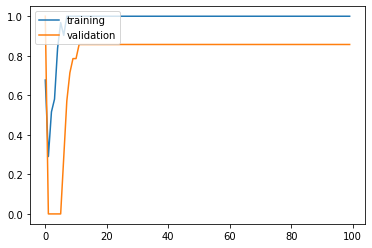

15/15 [==============================] - 0s 198us/step
Test accuracy:  0.9333333373069763


In [13]:
#모델을 다시 만들고 다시 돌린다.
model = Sequential()

model.add(Conv2D(input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3]),
                 filters = 32, kernel_size = (3,3), strides = (1,1), padding = 'same'))
model.add(Activation('relu'))

model.add(Conv2D(filters = 64, kernel_size = (3,3), strides = (1,1), padding = 'same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Flatten())    #1차원화

model.add(Dense(128, activation = 'relu'))
model.add(Dense(3, activation = 'softmax'))    #클래스가 3개니까!!!!!

adam = optimizers.Adam(lr = 0.001)

model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

#모델 확인하기
model.summary()

#학습시키기
history = model.fit(X_train, y_train, batch_size = 15, validation_split = 0.3, epochs = 100, verbose = 0)

#결과 확인
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'], loc = 'upper left')
plt.show()

results = model.evaluate(X_test, y_test)
print('Test accuracy: ', results[1])

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 24, 24, 32)        320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 32)        128       
_________________________________________________________________
activation_5 (Activation)    (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 24, 24, 64)        256       
_________________________________________________________________
activation_6 (Activation)    (None, 24, 24, 64)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 12, 12, 64)       

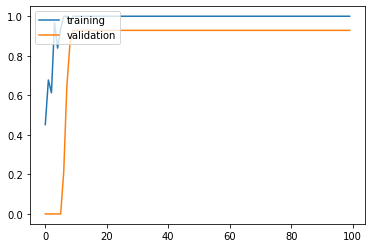

15/15 [==============================] - 0s 398us/step
Test accuracy:  0.9333333373069763


In [14]:
#최적화 몇가지 추가한다: bath normalization, kernel initializer, dropout 
model = Sequential()

model.add(Conv2D(input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3]),
                 filters = 32, kernel_size = (3,3), strides = (1,1), padding = 'same'))
model.add(BatchNormalization())   #batch normalization 추가
model.add(Activation('relu'))

model.add(Conv2D(filters = 64, kernel_size = (3,3), strides = (1,1), padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Flatten())

model.add(Dense(128, activation = 'relu', kernel_initializer='he_normal' ))
model.add(Dropout(0.3))    #dropout 추가
model.add(Dense(3, activation = 'softmax', kernel_initializer='he_normal'))

adam = optimizers.Adam(lr = 0.001)

model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

#모델 확인하기
model.summary()

#학습시키기
history = model.fit(X_train, y_train, batch_size = 15, validation_split = 0.3, epochs = 100, verbose = 0)

#결과 확인
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'], loc = 'upper left')
plt.show()

results = model.evaluate(X_test, y_test)
print('Test accuracy: ', results[1])

괜찮다.

non-trainable parameter
- 학습이 필요없는 파라미터
- batch normalization에서 도출된 파라미터임
- weight를 계산할 필요가 없는 파라미터 --> 해당 레이어를 출력해보면 weight가 없다.

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 22, 22, 32)        320       
_________________________________________________________________
batch_normalization_3 (Batch (None, 22, 22, 32)        128       
_________________________________________________________________
activation_7 (Activation)    (None, 22, 22, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 20, 20, 64)        18496     
_________________________________________________________________
batch_normalization_4 (Batch (None, 20, 20, 64)        256       
_________________________________________________________________
activation_8 (Activation)    (None, 20, 20, 64)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 10, 10, 64)       

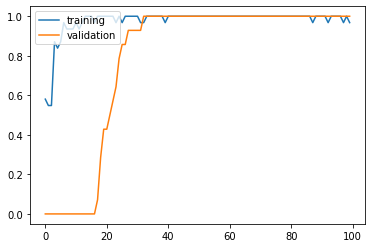

15/15 [==============================] - 0s 266us/step
Test accuracy:  0.9333333373069763


In [15]:
#패딩을 바꿔본다.
model = Sequential()

model.add(Conv2D(input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3]),
                 filters = 32, kernel_size = (3,3), strides = (1,1), padding = 'valid'))
model.add(BatchNormalization())   #batch normalization 추가
model.add(Activation('relu'))

model.add(Conv2D(filters = 64, kernel_size = (3,3), strides = (1,1), padding = 'valid'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Flatten())

model.add(Dense(128, activation = 'relu', kernel_initializer='he_normal' ))
model.add(Dropout(0.3))    #dropout 추가
model.add(Dense(3, activation = 'softmax', kernel_initializer='he_normal'))

adam = optimizers.Adam(lr = 0.001)

model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

#모델 확인하기
model.summary()

#학습시키기
history = model.fit(X_train, y_train, batch_size = 15, validation_split = 0.3, epochs = 100, verbose = 0)

#결과 확인
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'], loc = 'upper left')
plt.show()

results = model.evaluate(X_test, y_test)
print('Test accuracy: ', results[1])

딱히 차이가 없다.

In [16]:
# 솔루션

#학습셋
X_train = np.zeros((15*3, 24, 24))
y_train = np.zeros(15*3)

for i in range(15):
    img = cv2.imread('./hard_handwriting_shape/train/circle/circle{0:03d}.png'.format(i+1), 0)
    # '{0:03d}'.format(i+1) : {}에 format 메소드의 0번째 파라미터를 채워넣어라; 3자리의 숫자로 넣고, 빈자리는 0으로 채워라
    X_train[i, :, :] = img
    y_train[i, :, :] = 0
    
for i in range(15):
    img = cv2.imread('./hard_handwriting_shape/train/rectangle/rectangle{0:03d}.png'.format(i+1), 0)
    X_train[15+i, :, :] = img
    y_train[15+i, :, :] = 0
    
for i in range(15):
    img = cv2.imread('./hard_handwriting_shape/train/triangle/triangle{0:03d}.png'.format(i+1), 0)
    X_train[30+i, :, :] = img
    y_train[30+i, :, :] = 0
    
#테스트셋
X_test = np.zeros((5*3, 24, 24))
y_test = np.zeros(5*3)

for i in range(5):
    img = cv2.imread('./hard_handwriting_shape/test_easy/circle/circle{0:03d}.png'.format(i+1), 0)
    X_test[i, :, :] = img
    y_test[i, :, :] = 0
    
for i in range(5):
    img = cv2.imread('./hard_handwriting_shape/test_easy/rectangle/rectangle{0:03d}.png'.format(i+1), 0)
    X_test[15+i, :, :] = img
    y_test[15+i, :, :] = 0
    
for i in range(5):
    img = cv2.imread('./hard_handwriting_shape/test_easy/triangle/triangle{0:03d}.png'.format(i+1), 0)
    X_test[30+i, :, :] = img
    y_test[30+i, :, :] = 0

IndexError: too many indices for array

# 어려운 데이터로 한번 더 한다.

In [17]:
import os

shapes = ['circle', 'rectangle', 'triangle']

#학습셋
X_train = []
y_train = []

for shape in shapes:
    path = f"./hard_handwriting_shape/train/{shape}"
    file_list = os.listdir(path)
    file_path = [path + '/' + file for file in file_list if shape in file]
    X_train.extend([cv2.imread(x, 0) for x in file_path])
    y_train.extend([shapes.index(shape)] * len(file_path))
    
#테스트셋
X_test =  []
y_test = []

for shape in shapes:
    path = f"./hard_handwriting_shape/test/{shape}"
    file_list = os.listdir(path)
    file_path = [path + '/' + file for file in file_list if shape in file]
    X_test.extend([cv2.imread(x, 0) for x in file_path])
    y_test.extend([shapes.index(shape)] * len(file_path))
    
#array로 바꾸기
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [19]:
#데이터 전처리

#4차원 변환
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], -1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], -1)

#one-hot encoding
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 22, 22, 32)        320       
_________________________________________________________________
batch_normalization_10 (Batc (None, 22, 22, 32)        128       
_________________________________________________________________
activation_13 (Activation)   (None, 22, 22, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 20, 20, 64)        18496     
_________________________________________________________________
batch_normalization_11 (Batc (None, 20, 20, 64)        256       
_________________________________________________________________
activation_14 (Activation)   (None, 20, 20, 64)        0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 10, 10, 64)       

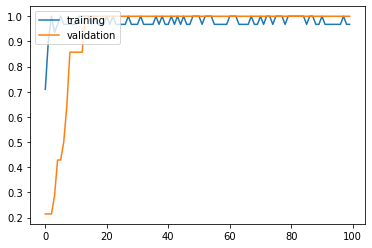

15/15 [==============================] - 0s 266us/step
Test accuracy:  0.3333333432674408


In [23]:
#모델 구축/학습/분류/평가
model = Sequential()

model.add(Conv2D(input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3]),
                 filters = 32, kernel_size = (3,3), strides = (1,1), padding = 'valid'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv2D(filters = 64, kernel_size = (3,3), strides = (1,1), padding = 'valid'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Flatten())

model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Dense(3, activation = 'softmax', kernel_initializer='he_normal'))

adam = optimizers.Adam(lr = 0.001)

model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

#모델 확인하기
model.summary()

#학습시키기
history = model.fit(X_train, y_train, batch_size = 15, validation_split = 0.3, epochs = 100, verbose = 0)

#결과 확인
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'], loc = 'upper left')
plt.show()

results = model.evaluate(X_test, y_test)
print('Test accuracy: ', results[1])

성능이 많이 떨어졌다.

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 22, 22, 32)        320       
_________________________________________________________________
batch_normalization_13 (Batc (None, 22, 22, 32)        128       
_________________________________________________________________
activation_16 (Activation)   (None, 22, 22, 32)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 20, 20, 64)        18496     
_________________________________________________________________
batch_normalization_14 (Batc (None, 20, 20, 64)        256       
_________________________________________________________________
activation_17 (Activation)   (None, 20, 20, 64)        0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 10, 10, 64)      

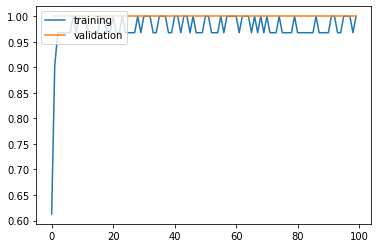

15/15 [==============================] - 0s 266us/step
Test accuracy:  0.3333333432674408


In [24]:
#층을 추가해보자
model = Sequential()

model.add(Conv2D(input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3]),
                 filters = 32, kernel_size = (3,3), strides = (1,1), padding = 'valid'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv2D(filters = 64, kernel_size = (3,3), strides = (1,1), padding = 'valid'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Flatten())

model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.3))

model.add(Dense(64))        #이 층을 추가했다.
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Dense(3, activation = 'softmax', kernel_initializer='he_normal'))

adam = optimizers.Adam(lr = 0.001)

model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

#모델 확인하기
model.summary()

#학습시키기
history = model.fit(X_train, y_train, batch_size = 15, validation_split = 0.3, epochs = 100, verbose = 0)

#결과 확인
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'], loc = 'upper left')
plt.show()

results = model.evaluate(X_test, y_test)
print('Test accuracy: ', results[1])

딱히 개선되지 않는다.

인식률이 0.33으로 계속 비슷하게 나오는 이유 == 항상 틀리는 것만 틀리기 때문

## 어떻게 해결해야할까?
근본적으로 네트워크 문제가 아니다.

(트레인 데이터를 왜곡한다.)

# 2. 성능 개선하기

## 2-1. 모델 뜯어보기

실제로 계산된 weight를 눈으로 확인하면서 무엇이 문제인지 확인해보자.
- model도 하나의 객체이기 때문에 속성값을 갖고 있다.
    - `모델.layers`
        - 모델을 구성하고 있는 레이어들을 요소로 갖는 **리스트**를 반환
        - `레이어.name`
            - 해당 레이어의 이름을 리턴한다.
        - `레이어.get_weights()`
            - 해당 레이어의 weight와 bias를 리턴한다.
            - `w[0]`: weight
            - `w[1]`: bias
        - `레이어.output`
            - 해당 레이어의 출력값을 반환; wx + b값

In [29]:
model.layers

In [33]:
for l in model.layers:
    print(l.name)    #각 레이어의 이름 출력

conv2d_15
batch_normalization_13
activation_16
conv2d_16
batch_normalization_14
activation_17
max_pooling2d_8
flatten_8
dense_14
batch_normalization_15
activation_18
dropout_5
dense_15
batch_normalization_16
activation_19
dense_16


In [35]:
w = model.layers[0].get_weights()    #0번째 레이어의 weight값 리턴
print(w[0].shape)    #필터 weight
print(w[1].shape)    #바이어스

(3, 3, 1, 32)
(32,)


3 * 3 필터가 32개 있기 때문에 위와 같은 값이 출력된다.

In [45]:
print(w[0][:, :, 0, 0])   #0번째 필터 weight
print(w[0][:, :, 0, 1])   #1번째 필터 weight

print('-----------------------------------------------')

print(w[1][0])            #0번째 필터 bias
print(w[1][1])            #1번째 필터 bias

[[ 0.12639287  0.06010088 -0.07203404]
 [ 0.07878254 -0.077664    0.06688038]
 [-0.09887184  0.02531194 -0.06547181]]
[[ 0.00417639  0.13769932  0.05842807]
 [-0.11849122 -0.10152902 -0.00888197]
 [ 0.14137731  0.11752501 -0.1096666 ]]
-----------------------------------------------
4.9530176e-05
5.921685e-06


In [42]:
model.layers[0].output   #0번째 레이어의 출력값 리턴

<tf.Tensor 'conv2d_15/BiasAdd:0' shape=(None, 22, 22, 32) dtype=float32>

## 2-2. 중간 결과 출력해보기
중간 결과를 출력해보기 위해서는 별도의 모델을 만들어야한다.
- my_layer_model = Model(inputs, outputs)

- 모델 생성 후 `predict` 메소드를 활용해서 중간 결과를 출력할 수 있다.
    - `predict` 메소드를 쓰기는 하지만, 학습시키는 것이라기보다는 데이터를 쭉 흘려보내서 계산을 해달라는 것으로 생각하면 된다.
    

In [57]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 22, 22, 32)        320       
_________________________________________________________________
batch_normalization_13 (Batc (None, 22, 22, 32)        128       
_________________________________________________________________
activation_16 (Activation)   (None, 22, 22, 32)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 20, 20, 64)        18496     
_________________________________________________________________
batch_normalization_14 (Batc (None, 20, 20, 64)        256       
_________________________________________________________________
activation_17 (Activation)   (None, 20, 20, 64)        0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 10, 10, 64)      

In [52]:
from keras.models import Model

my_layer_model = Model(inputs = model.input,
                      outputs = model.layers[0].output)   #0번 레이어의 아웃풋을 보기 위해
output = my_layer_model.predict(X_test)
print(output.shape)

(15, 22, 22, 32)


15개 output, 이미지 w(22), 이미지 h(22), 32개 필터

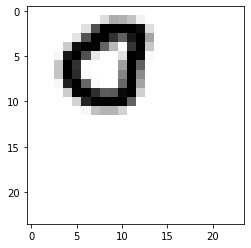

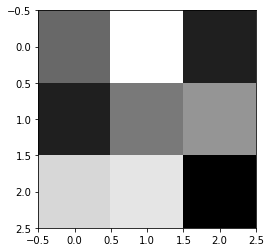

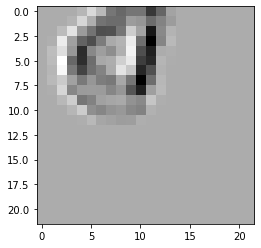

In [60]:
iFilter = 5
iImg = 1

#원본 이미지 출력
plt.imshow(X_test[iImg, :, :, 0], cmap = 'gray')   #1번 이미지, 0번 채널
plt.show()

#필터
w = model.layers[0].get_weights()     #0번 레이어
w = w[0]                              #weight
f = w[:, :, 0, iFilter]               #5번 필터
plt.imshow(f, cmap = 'gray')
plt.show()

#필터 적용
plt.imshow(output[iImg, :, :, iFilter], cmap = 'gray')   #1번 이미지에 5번 필터
plt.show()

### 2-2-1. Flatten layer의 출력값 확인하기

- flatten layer에서 **특징 추출**이 이루어지기 때문에 flatten layer의 출력값을 자주 확인하게 될 것.

- `get_layer` 메소드를 써서 레이어의 이름으로 레이어에 접근할 수 있다.

In [80]:
flatten_layer_model = Model(inputs = model.input,
                           outputs = model.get_layer("flatten_8").output)

output = flatten_layer_model.predict(X_test)   #예측함수 아님!!

print(output.shape)
print(output)

(15, 6400)
[[0.         2.4374456  0.51140547 ... 0.5203948  0.         0.23098007]
 [0.         0.         0.8209227  ... 0.5203948  0.         0.23098007]
 [0.         0.         0.15982687 ... 0.5203948  0.         0.23098007]
 ...
 [0.         0.         0.15982687 ... 0.5203948  0.         0.23098007]
 [0.         0.         0.15982687 ... 0.5203948  0.         0.23098007]
 [0.         0.         0.15982687 ... 0.53686166 0.68517953 0.7417007 ]]


In [76]:
model.get_layer('flatten_8').get_weights()

[]

flatten layer는 단순히 1차원화 해주는 층이기 때문에 계산된 weight가 따로 없다.

### 2-2-2. Output layer의 출력값 확인하기

In [82]:
output_layer_model = Model(inputs = model.input,
                           outputs = model.get_layer("dense_16").output)

output = output_layer_model.predict(X_test)   #예측함수 아님!!

print(output.shape)
print(output)

(15, 3)
[[3.4532398e-02 9.8735526e-02 8.6673206e-01]
 [8.0481641e-02 4.0645432e-02 8.7887287e-01]
 [1.3411517e-03 6.1762142e-03 9.9248260e-01]
 [6.7449466e-04 7.1042211e-04 9.9861503e-01]
 [5.2359897e-05 7.2729890e-05 9.9987495e-01]
 [2.6852646e-01 1.1615152e-01 6.1532205e-01]
 [2.5573138e-03 1.7833360e-02 9.7960931e-01]
 [3.0280235e-03 1.2509051e-03 9.9572104e-01]
 [3.9196541e-03 1.0884539e-02 9.8519576e-01]
 [1.2373872e-03 1.0645988e-03 9.9769801e-01]
 [3.5904506e-03 5.1308256e-03 9.9127871e-01]
 [6.1559945e-04 9.3225110e-04 9.9845219e-01]
 [1.5001911e-03 4.0212800e-03 9.9447846e-01]
 [1.5156399e-03 3.2070987e-03 9.9527729e-01]
 [2.1978177e-02 1.8129164e-01 7.9673016e-01]]


이미지 15개의 3개 클래스에 대한 확률을 계산했기 때문에 위와 같은 출력값이 나온다.

- e.g. 첫 줄은 0번째 데이터의 각 클래스에 대한 확률
    - 3번째 클래스일 확률이 가장 높게 나온 것


- 넘파이의 `argmax` 메소드를 통해 출력값을 좀 더 직관적으로 바꿀 수 있다.

In [83]:
np.argmax(output, axis = 1)

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int64)

죄다 삼각형이란다.

결국 아까 인식률이 0.33 나온 건, 다 하나로 찍어서 그런 거였다.

=> 학습이 하나도 안 이루어짐.

In [94]:
#예측 라벨
p = np.argmax(output, axis = 1)
print(p)

#실제 라벨
t = np.argmax(y_test, axis = 1)
print(t)

#인식률 계산
print(p == t)
print((p == t)*1)
print(((p == t) * 1).sum() / len(p))

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
[0 0 0 0 0 1 1 1 1 1 2 2 2 2 2]
[False False False False False False False False False False  True  True
  True  True  True]
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
0.3333333333333333


# 3. 데이터 부풀리기(Augmentation)

> 데이터 수를 늘림으로써 train data set 크기의 한계로 인한 저성능을 해결하는 것.

- 근처의 비슷한 데이터(noise)를 가상으로 만들어준다.
    - translation
    - rotation
    - change in scale
    - shearing
    - horizontal(vertical) flip
    
- 모든 변형을 넣어주는 게 좋을까?
    - 오히려 성능이 떨어질 수 있다.
    - 케이스별로 적절한 변형 형태를 적용해야한다.
    


CNN에서 필터에 weight가 있다는 것은 무슨 의미일까?

텐서란 뭘까?
- numpy 객체와 비슷하다.
- 